In [13]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys

from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import geopandas as gpd

In [14]:
# Path to your shapefile
hurricane = "milton"
storm_path = "../data/storm_track/milton_storm_track.shp"
# Read the shapefile
gdf_milton = gpd.read_file(storm_path)

In [15]:
gdf_milton.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
gdf = gpd.read_file('../data/county_geo/tl_2023_us_county/tl_2023_us_county.shp')
gdf['GEOID'] = gdf['GEOID'].astype(int)

In [17]:
gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [18]:
projected_crs = "EPSG:5070"  # USA Contiguous Albers Equal Area
storm_track = gdf_milton.to_crs(projected_crs)
county_centers = gdf.to_crs(projected_crs)

In [19]:
state_fp = pd.read_csv('state_fp.csv')
state_codes = state_fp['State (FIPS)'].unique()
gdf_states = county_centers[county_centers['STATEFP'].astype(int).isin(state_codes)]
SE_states = ['01','05','12','13','21','22','28','37','45','47','51','54']
gdf_SE = gdf_states[gdf_states['STATEFP'].isin(SE_states)].copy()

[]

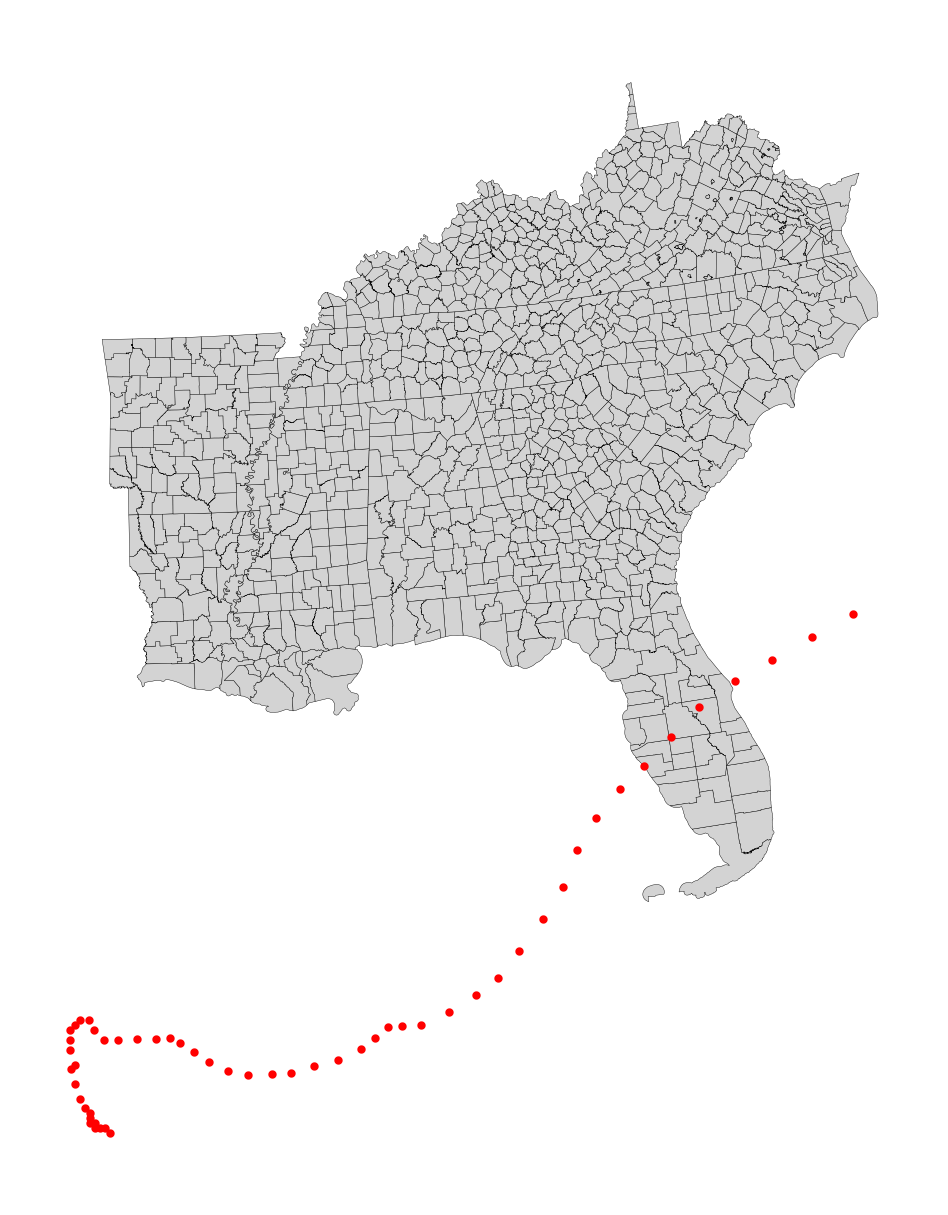

In [20]:
fig, ax = plt.subplots(figsize=(5, 5),dpi=300)

gdf_SE.plot(ax=ax, color='lightgray', edgecolor='black',lw=0.1)
storm_track.plot(ax=ax, color='red',markersize=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

In [21]:
storm_track["on_land"] = storm_track.geometry.apply(
    lambda point: gdf_SE.geometry.distance(point).min() <= 12000  # Within 5 km
)
storm_track["on_land"].sum()

np.int64(4)

In [22]:
gdf_SE_buffer = gdf_SE.copy()
gdf_SE_buffer["geometry"] = gdf_SE_buffer.geometry.buffer(12000)  # Buffer by 1 km
storm_track_on_land = gpd.sjoin(storm_track, gdf_SE_buffer, how="inner", predicate="intersects")

no. selected counties 8
no. selected counties 13
no. selected counties 21
no. selected counties 34


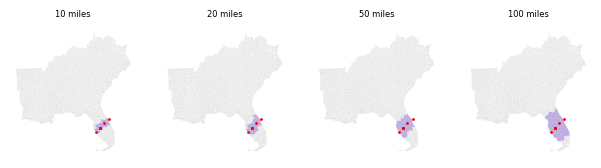

In [23]:
from shapely.geometry import LineString
storm_line = LineString(storm_track_on_land.geometry.tolist())

mile_cutoff_ls = [10,50,100,200]  # 200 miles
fig, axs = plt.subplots(1, 4, figsize=(7.5, 2))
for idx,ax in enumerate(axs):
    mile_cutoff = mile_cutoff_ls[idx]
    buffer_distance = mile_cutoff * 1609.34  # 200 miles in meters
    # Step 1: Create a 200-mile buffer around the storm track
    # storm_buffer = storm_track_on_land.geometry.buffer(buffer_distance)
    storm_buffer = storm_line.buffer(buffer_distance)
    # Combine the buffered geometries into a single geometry
    # storm_buffer_union = storm_buffer.unary_union
    # Step 2: Find counties within the buffer
    counties_within_buffer = gdf_SE[gdf_SE.geometry.intersects(storm_buffer)]
    # Step 3: Extract county names or IDs

    county_list = counties_within_buffer['GEOID'].to_list()
    print('no. selected counties', len(county_list))
    ##Save list to a text file
    with open("../results/{}/counties_geoid_cut_{}.txt" .format(hurricane, mile_cutoff), "w") as f:
        for item in county_list:
            f.write(f"{item}\n")
    # Plot the results
    gdf_SE.plot(ax=ax, color="lightgrey", edgecolor="white",alpha=0.5,lw=0.2)  # Plot counties
    # storm_buffer.plot(ax=ax, color="green", alpha=0.3)
    gdf_SE[gdf_SE.geometry.intersects(storm_buffer)].plot(ax=ax, color="mediumpurple", edgecolor="None",alpha=0.5)  # Highlight selected counties
    storm_track_on_land.plot(ax=ax, color="red", markersize=1)  # Plot storm track
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title("{} miles".format(mile_cutoff),fontsize=6)
# plt.show()
# plt.savefig(f'../results/milton/storm_tracks.png', format = 'png',dpi=450,bbox_inches='tight',transparent=True)